# **Step 1: Import Libraries & Load Datasets**

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load all datasets
customers = pd.read_csv('/content/olist_customers_dataset.csv')
geolocation = pd.read_csv('/content/olist_geolocation_dataset.csv')
order_items = pd.read_csv('/content/olist_order_items_dataset.csv')
payments = pd.read_csv('/content/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('/content/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/content/olist_orders_dataset.csv')
products = pd.read_csv('/content/olist_products_dataset.csv')
sellers = pd.read_csv('/content/olist_sellers_dataset.csv')
category_translation = pd.read_csv('/content/product_category_name_translation.csv')

In [3]:
# Check Shapes of All Datasets
for name, df in {
    "Customers": customers,
    "Geolocation": geolocation,
    "Order Items": order_items,
    "Order Reviews": order_reviews,
    "Orders": orders,
    "Products": products,
    "Sellers": sellers,
    "Category Translation": category_translation,
    "Payments": payments
}.items():
    print(f"{name:<22} → Rows: {df.shape[0]:<6} Columns: {df.shape[1]}")

Customers              → Rows: 99441  Columns: 5
Geolocation            → Rows: 1000163 Columns: 5
Order Items            → Rows: 112650 Columns: 7
Order Reviews          → Rows: 99224  Columns: 7
Orders                 → Rows: 99441  Columns: 8
Products               → Rows: 32951  Columns: 9
Sellers                → Rows: 3095   Columns: 4
Category Translation   → Rows: 71     Columns: 2
Payments               → Rows: 103886 Columns: 5


# **Step 2: Data Preparation + Merging**

In [4]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
orders["order_status"].value_counts()

,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


In [6]:
# Adding a new column (is_returned for products that have been returned)

orders_clean = orders.copy()
orders_clean["is_returned"] = orders_clean["order_status"].apply(lambda x: 1 if x == "canceled" else 0)
orders_clean["is_returned"].value_counts()

,count
is_returned,
0,98816
1,625


In [7]:
# Merging orders and order_items on 'order_id'
df_orders_items = pd.merge(orders_clean, order_items, on = "order_id", how = "inner")
df_orders_items.shape

(112650, 15)

In [8]:
df_order_items_products = pd.merge(df_orders_items, products, on = "product_id", how = "left")
df_orders_items.shape

(112650, 15)

In [9]:
df_orders_full = pd.merge(df_order_items_products, category_translation, on = "product_category_name", how = "left")
df_orders_full.shape

(112650, 24)

In [10]:
df_orders_full = pd.merge(df_orders_full, payments, on = "order_id", how = "left")
df_orders_full.shape

(117604, 28)

In [11]:
df_orders_full = pd.merge(df_orders_full, order_reviews, on = "order_id", how = "left")
df_orders_full.shape

(118310, 34)

In [12]:
df_orders_full = pd.merge(df_orders_full, customers, on = "customer_id", how = "left")
df_orders_full.shape

(118310, 38)

In [13]:
print("seller_id" in df_orders_full.columns)
print(df_orders_full["seller_id"].nunique())

True
3095


In [14]:
df_orders_full = df_orders_full.merge(sellers, on = "seller_id", how = "left")
print(f"Shape after merging sellers: {df_orders_full.shape}")
print(df_orders_full[["seller_id", "seller_city", "seller_state"]].head())

Shape after merging sellers: (118310, 41)
                          seller_id     seller_city seller_state
0  3504c0cb71d7fa48d967e0e4c94d59d9            maua           SP
1  3504c0cb71d7fa48d967e0e4c94d59d9            maua           SP
2  3504c0cb71d7fa48d967e0e4c94d59d9            maua           SP
3  289cdb325fb7e7f891c38608bf9e0962  belo horizonte           SP
4  4869f7a5dfa277a7dca6462dcf3b52b2         guariba           SP


In [15]:
df_orders_full.isnull().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,15
order_delivered_carrier_date,1254
order_delivered_customer_date,2588
order_estimated_delivery_date,0
is_returned,0
order_item_id,0


In [16]:
df_orders_full["order_purchase_timestamp"] = pd.to_datetime(df_orders_full["order_purchase_timestamp"])
df_orders_full["order_delivered_customer_date"] = pd.to_datetime(df_orders_full["order_delivered_customer_date"])
df_orders_full["order_estimated_delivery_date"] = pd.to_datetime(df_orders_full["order_estimated_delivery_date"])

In [17]:
df_orders_full["actual_delivery_days"] = (df_orders_full["order_delivered_customer_date"] - df_orders_full["order_purchase_timestamp"]).dt.days
df_orders_full["delivery_delay"] = (df_orders_full["order_delivered_customer_date"] - df_orders_full["order_estimated_delivery_date"]).dt.days

In [18]:
df_orders_full["review_score_sentiment"] = df_orders_full["review_score"].apply(lambda x : "Excellent" if x == 5 else("Good" if x == 4 else ("Neutral" if x == 3 else "Bad")))

In [19]:
df_orders_full["review_score_sentiment"].value_counts()

,count
review_score_sentiment,
Excellent,66264
Good,22286
Bad,19920
Neutral,9840


In [20]:
df_orders_full["payment_per_installment"] = df_orders_full["payment_value"] / df_orders_full["payment_installments"]

In [21]:
df_orders_full["payment_per_installment"].head()

,payment_per_installment
0,18.120000
1,2.000000
2,18.590000
3,141.460000
4,59.706667


In [22]:
df_orders_full["product_category_name_english"].head()

,product_category_name_english
0,housewares
1,housewares
2,housewares
3,perfumery
4,auto


In [23]:
df_orders_full.rename(columns = {"product_category_name_english": "product_category"}, inplace = True)

In [24]:
df_orders_full["product_category"].head()

,product_category
0,housewares
1,housewares
2,housewares
3,perfumery
4,auto


In [25]:
df_orders_full[['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'actual_delivery_days', 'delivery_delay']].head()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,actual_delivery_days,delivery_delay
0,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8.0,-8.0
1,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8.0,-8.0
2,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8.0,-8.0
3,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,13.0,-6.0
4,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9.0,-18.0


# **Step 3: Insights**

In [26]:
# Return rate by product category

category_returns = df_orders_full.groupby("product_category").agg(
    total_orders = ("order_id", "count"),
    returned_orders = ("is_returned", "sum")
).reset_index()

category_returns["return_rate_%"] = (category_returns["returned_orders"] / category_returns["total_orders"]) *100

category_returns = category_returns.sort_values(by = "return_rate_%", ascending = False)

category_returns.head(10)

,product_category,total_orders,returned_orders,return_rate_%
25,dvds_blu_ray,71,3,4.225352
23,diapers_and_hygiene,39,1,2.564103
19,construction_tools_safety,199,5,2.512563
21,costruction_tools_garden,247,4,1.619433
56,musical_instruments,719,11,1.529903
34,fixed_telephony,272,4,1.470588
8,books_general_interest,565,7,1.238938
63,small_appliances,705,8,1.134752
45,home_appliances_2,270,3,1.111111
51,kitchen_dining_laundry_garden_furniture,299,3,1.003344


In [27]:
revenue_by_category = df_orders_full.groupby("product_category")["price"].sum().reset_index()
revenue_by_category = revenue_by_category.sort_values(by = "price", ascending = False).head(10)
print(revenue_by_category)

         product_category       price
43          health_beauty  1301947.97
70          watches_gifts  1254322.95
7          bed_bath_table  1107249.09
65         sports_leisure  1029603.88
15  computers_accessories   950053.69
39        furniture_decor   772096.17
49             housewares   668880.94
20             cool_stuff   664637.13
5                    auto   618395.50
42           garden_tools   519473.33


In [28]:
delay_by_category = df_orders_full.groupby("product_category")["delivery_delay"].mean().reset_index()
delay_by_category = delay_by_category.sort_values(by="delivery_delay", ascending=False).head(10)
print(delay_by_category)

                     product_category  delivery_delay
3               arts_and_craftmanship       -6.791667
41  furniture_mattress_and_upholstery       -7.175000
46                     home_comfort_2       -8.483871
47                       home_confort       -9.788584
36                               food       -9.953398
4                               audio      -10.224274
33            fashion_underwear_beach      -10.707143
9                      books_imported      -11.050847
26                        electronics      -11.147436
18          construction_tools_lights      -11.173633


In [29]:
payment_by_category = df_orders_full.groupby("product_category")["payment_value"].mean().reset_index()
payment_by_category = payment_by_category.sort_values(by="payment_value", ascending=False).head(10)
print(payment_by_category)

                         product_category  payment_value
14                              computers    1268.734318
34                        fixed_telephony     761.290625
64  small_appliances_home_oven_and_coffee     656.786154
0              agro_industry_and_commerce     471.153214
45                      home_appliances_2     462.466370
57                       office_furniture     364.662472
62                 signaling_and_security     340.736567
19              construction_tools_safety     330.105678
56                    musical_instruments     324.341725
63                       small_appliances     321.491830


In [30]:
review_by_category = df_orders_full.groupby("product_category")["review_score"].mean().reset_index()
review_by_category = review_by_category.sort_values(by="review_score", ascending=False).head(10)
print(review_by_category)

                         product_category  review_score
11                      cds_dvds_musicals      4.642857
29              fashion_childrens_clothes      4.500000
8                  books_general_interest      4.438503
9                          books_imported      4.419355
35                                flowers      4.419355
22                costruction_tools_tools      4.415842
10                        books_technical      4.375465
37                             food_drink      4.324138
64  small_appliances_home_oven_and_coffee      4.320513
53                    luggage_accessories      4.295945


In [31]:
# Group by customer state and calculate return stats
state_returns = df_orders_full.groupby("customer_state").agg(
    total_orders = ("order_id", "count"),
    returned_orders = ("is_returned", "sum")
).reset_index()

# Calculate return rate %
state_returns["return_rate_%"] = (state_returns["returned_orders"] / state_returns["total_orders"]) * 100

# Sort by highest return rate
state_returns = state_returns.sort_values(by="return_rate_%", ascending=False)

# Display top 10 states
state_returns.head(10)

,customer_state,total_orders,returned_orders,return_rate_%
21,RR,52,1,1.923077
16,PI,574,4,0.696864
25,SP,49865,306,0.613657
18,RJ,15425,74,0.479741
9,MA,849,4,0.471143
8,GO,2453,11,0.448430
7,ES,2351,10,0.425351
10,MG,13718,58,0.422802
17,PR,5988,23,0.384102
4,BA,4068,15,0.368732


In [32]:
# Group by seller_id to compute return stats
seller_returns = df_orders_full.groupby("seller_id").agg(
    total_orders = ("order_id", "count"),
    returned_orders = ("is_returned", "sum")
).reset_index()

# Add return rate %
seller_returns["return_rate_%"] = (seller_returns["returned_orders"] / seller_returns["total_orders"]) * 100

# Sort by return rate and show top 10
seller_returns = seller_returns.sort_values(by="return_rate_%", ascending=False)

# Filter to show only sellers with at least 10 orders for more reliability
seller_returns_filtered = seller_returns[seller_returns["total_orders"] >= 10]

seller_returns_filtered.head(10)

,seller_id,total_orders,returned_orders,return_rate_%
196,10ff823eda2b032e2c93d17a7d294736,17,9,52.941176
2005,a4b6b9b992b46e9ef863637af96e04bc,14,6,42.857143
2378,c4f7fee5b0db50e87766f5a4d1b1b758,10,4,40.000000
1355,6ee85be3693ed79a8e80718743d80655,13,5,38.461538
1592,81783131d2a97c8d44d406a4be81b5d9,16,6,37.500000
2921,f1c1ac3f3efc07e659c035008e615e66,14,5,35.714286
946,4e8dacf3d38f281ae26c3e0321d92d88,15,5,33.333333
2065,ab3e0c171fe84a7ba7de130f19cfb485,10,3,30.000000
579,312ba1d77e9c332ef21f9598b7f64cd7,11,3,27.272727
3094,ffff564a4f9085cd26170f4732393726,20,4,20.000000


In [33]:
# Group by product category
delivery_delays = df_orders_full.groupby("product_category").agg(
    total_orders = ("order_id", "count"),
    avg_delivery_days = ("actual_delivery_days", "mean"),
    avg_delay = ("delivery_delay", "mean")
).reset_index()

# Sort by average delay descending
delivery_delays = delivery_delays.sort_values(by="avg_delay", ascending=False)

delivery_delays.head(10)

,product_category,total_orders,avg_delivery_days,avg_delay
3,arts_and_craftmanship,24,5.291667,-6.791667
41,furniture_mattress_and_upholstery,41,13.700000,-7.175000
46,home_comfort_2,31,13.806452,-8.483871
47,home_confort,478,12.947146,-9.788584
36,food,526,9.116505,-9.953398
4,audio,381,12.854881,-10.224274
33,fashion_underwear_beach,144,13.078571,-10.707143
9,books_imported,62,7.847458,-11.050847
26,electronics,2846,12.433761,-11.147436
18,construction_tools_lights,314,9.160772,-11.173633


In [34]:
# Group by product_category
category_reviews_returns = df_orders_full.groupby("product_category").agg(
    total_orders=("order_id", "count"),
    returned_orders=("is_returned", "sum"),
    avg_review_score=("review_score", "mean")
).reset_index()

# Add return rate %
category_reviews_returns["return_rate_%"] = (category_reviews_returns["returned_orders"] / category_reviews_returns["total_orders"]) * 100

# Sort by return rate descending
category_reviews_returns = category_reviews_returns.sort_values(by="return_rate_%", ascending=False)

# View top 10
category_reviews_returns.head(10)

,product_category,total_orders,returned_orders,avg_review_score,return_rate_%
25,dvds_blu_ray,71,3,4.114286,4.225352
23,diapers_and_hygiene,39,1,3.256410,2.564103
19,construction_tools_safety,199,5,3.848485,2.512563
21,costruction_tools_garden,247,4,4.080972,1.619433
56,musical_instruments,719,11,4.157303,1.529903
34,fixed_telephony,272,4,3.672862,1.470588
8,books_general_interest,565,7,4.438503,1.238938
63,small_appliances,705,8,4.155937,1.134752
45,home_appliances_2,270,3,4.212687,1.111111
51,kitchen_dining_laundry_garden_furniture,299,3,3.962963,1.003344


In [35]:
# Bin delivery delays
def delay_label(days):
    if days < 0:
        return "Early"
    elif days == 0:
        return "On Time"
    else:
        return "Late"

df_orders_full["delivery_status"] = df_orders_full["delivery_delay"].apply(delay_label)

# Group by delivery_status and calculate average review score
delay_review_analysis = df_orders_full.groupby("delivery_status").agg(
    avg_review_score=("review_score", "mean"),
    order_count=("order_id", "count")
).reset_index()

# Sort delivery status manually (optional for nice chart in Power BI)
delay_review_analysis["delivery_status"] = pd.Categorical(
    delay_review_analysis["delivery_status"], categories=["Early", "On Time", "Late"], ordered=True
)
delay_review_analysis = delay_review_analysis.sort_values("delivery_status")

delay_review_analysis

,delivery_status,avg_review_score,order_count
0,Early,4.208608,106654
2,On Time,3.991304,1509
1,Late,2.128265,10147


In [36]:
# Group by payment type
payment_summary = payments.groupby("payment_type").agg(
    total_value = ("payment_value", "sum"),
    average_transaction = ("payment_value", "mean"),
    total_orders = ("order_id", "count")
).reset_index().sort_values(by="total_value", ascending=False)

payment_summary

,payment_type,total_value,average_transaction,total_orders
1,credit_card,12542084.19,163.319021,76795
0,boleto,2869361.27,145.034435,19784
4,voucher,379436.87,65.703354,5775
2,debit_card,217989.79,142.570170,1529
3,not_defined,0.00,0.000000,3


In [37]:
#Preparing RFM Data
import datetime as dt

# Only delivered orders
rfm_df = df_orders_full[df_orders_full['order_status'] == 'delivered'].copy()

# Set reference date (max purchase + 1)
ref_date = rfm_df['order_purchase_timestamp'].max() + dt.timedelta(days=1)

# RFM Aggregation
rfm = rfm_df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (ref_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
}).reset_index()

# Rename columns
rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

In [38]:
# Creating Segments
# Assign quantiles
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

# Final RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [39]:
# Basic segmentation
def segment_customer(row):
    if row['RFM_Score'] == '444':
        return 'Champions'
    elif row['R_Score'] == 4 and row['F_Score'] >= 3:
        return 'Loyal'
    elif row['R_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Potential'
    elif row['R_Score'] == 1:
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

In [40]:
# Return rate by delivery status
delivery_returns = df_orders_full.groupby("delivery_status").agg(
    total_orders = ("order_id", "count"),
    returned_orders = ("is_returned", "sum")
).reset_index()

# Calculate return rate
delivery_returns["return_rate_%"] = (delivery_returns["returned_orders"] / delivery_returns["total_orders"]) * 100

# Sort for readability
delivery_returns = delivery_returns.sort_values(by="return_rate_%", ascending=False)
delivery_returns

,delivery_status,total_orders,returned_orders,return_rate_%
1,Late,10147,564,5.558293
0,Early,106654,6,0.005626
2,On Time,1509,0,0.000000


In [41]:
# Group by price buckets
df_orders_full["price_bucket"] = pd.cut(df_orders_full["price"],
                                        bins=[0, 50, 100, 200, 500, 1000, 2000, df_orders_full["price"].max()],
                                        labels=["0-50", "51-100", "101-200", "201-500", "501-1000", "1001-2000", "2000+"])


# Return rate by price bucket
price_returns = df_orders_full.groupby("price_bucket").agg(
    total_orders=("order_id", "count"),
    returned_orders=("is_returned", "sum")
).reset_index()

price_returns["return_rate_%"] = (price_returns["returned_orders"] / price_returns["total_orders"]) * 100

price_returns

,price_bucket,total_orders,returned_orders,return_rate_%
0,0-50,41352,187,0.452215
1,51-100,34862,144,0.413057
2,101-200,28036,123,0.438722
3,201-500,10668,83,0.778028
4,501-1000,2501,16,0.639744
5,1001-2000,762,10,1.312336
6,2000+,129,7,5.426357


In [42]:
# Revenue loss due to returns
returns_loss = df_orders_full[df_orders_full["is_returned"] == 1]

total_loss = returns_loss["payment_value"].sum()

print(f"💸 Estimated Revenue Lost Due to Returns: ₹{total_loss:,.2f}")

💸 Estimated Revenue Lost Due to Returns: ₹150,616.44


In [43]:
# Month-wise Order & Return Trend
df_orders_full['order_purchase_month'] = pd.to_datetime(df_orders_full['order_purchase_timestamp']).dt.to_period('M')

monthly_returns = df_orders_full.groupby('order_purchase_month').agg(
    total_orders=('order_id', 'count'),
    returned_orders=('is_returned', 'sum')
).reset_index()

monthly_returns['return_rate_%'] = (monthly_returns['returned_orders'] / monthly_returns['total_orders']) * 100
monthly_returns.head()

,order_purchase_month,total_orders,returned_orders,return_rate_%
0,2016-09,6,1,16.666667
1,2016-10,385,14,3.636364
2,2016-12,1,0,0.000000
3,2017-01,1023,2,0.195503
4,2017-02,2073,15,0.723589


In [44]:
#Repeat vs New Customers – Return Behavior

# Count total orders per customer
customer_order_counts = df_orders_full.groupby('customer_id')['order_id'].nunique().reset_index()
customer_order_counts.columns = ['customer_id', 'total_orders_by_customer']

# Merge with main dataframe
df_orders_full = df_orders_full.merge(customer_order_counts, on='customer_id', how='left')

# Categorize them
df_orders_full['customer_type'] = df_orders_full['total_orders_by_customer'].apply(lambda x: 'New' if x == 1 else 'Repeat')

# Now analyze return rate
repeat_analysis = df_orders_full.groupby('customer_type').agg(
    total_orders=('order_id', 'count'),
    returned_orders=('is_returned', 'sum')
).reset_index()

repeat_analysis['return_rate_%'] = (repeat_analysis['returned_orders'] / repeat_analysis['total_orders']) * 100
repeat_analysis

,customer_type,total_orders,returned_orders,return_rate_%
0,New,118310,570,0.481785


In [45]:
# Group by delivery status
delivery_review_return = df_orders_full.groupby("delivery_status").agg(
    total_orders=("order_id", "count"),
    avg_review_score=("review_score", "mean"),
    returned_orders=("is_returned", "sum")
).reset_index()

# Calculate return rate
delivery_review_return["return_rate_%"] = (delivery_review_return["returned_orders"] / delivery_review_return["total_orders"]) * 100

# Round the values for better readability
delivery_review_return = delivery_review_return.round({
    "avg_review_score": 2,
    "return_rate_%": 2
})

delivery_review_return

,delivery_status,total_orders,avg_review_score,returned_orders,return_rate_%
0,Early,106654,4.21,6,0.01
1,Late,10147,2.13,564,5.56
2,On Time,1509,3.99,0,0.00


In [46]:
# Analyze Time to Return

# Convert timestamps to datetime
df_orders_full["order_purchase_timestamp"] = pd.to_datetime(df_orders_full["order_purchase_timestamp"])
df_orders_full["order_approved_at"] = pd.to_datetime(df_orders_full["order_approved_at"])

# Filter only returned (cancelled) orders
returned_orders = df_orders_full[df_orders_full["is_returned"] == 1].copy()

# Calculate time to return (approval - purchase)
returned_orders["time_to_cancel_hours"] = (returned_orders["order_approved_at"] - returned_orders["order_purchase_timestamp"]).dt.total_seconds() / 3600

# Check basic stats
returned_orders["time_to_cancel_hours"].describe()

,time_to_cancel_hours
count,570.000000
mean,11.987726
std,46.816622
min,0.000000
25%,0.210278
50%,0.326944
75%,12.912153
max,781.028056


In [47]:
# Define buckets
bins = [0, 1, 6, 12, 24, 48, 168, float('inf')]
labels = ['<1 hr', '1–6 hrs', '6–12 hrs', '12–24 hrs', '1–2 days', '2–7 days', '7+ days']

# Create a new column for the bucket
returned_orders['cancel_time_bucket'] = pd.cut(returned_orders['time_to_cancel_hours'], bins=bins, labels=labels)

# Group and count
cancel_time_dist = returned_orders['cancel_time_bucket'].value_counts().sort_index().reset_index()
cancel_time_dist.columns = ['cancel_time_bucket', 'count']
cancel_time_dist

,cancel_time_bucket,count
0,<1 hr,358
1,1–6 hrs,37
2,6–12 hrs,11
3,12–24 hrs,62
4,1–2 days,58
5,2–7 days,28
6,7+ days,3


# **Step 4: Machine Learning**

In [48]:
# Preparing the Customer-Level Dataset

customer_df = df_orders_full.groupby("customer_unique_id").agg({
    "order_id": "count",
    "payment_value": "sum",
    "is_returned": "sum",
    "review_score": "mean"
}).reset_index()

# Rename for clarity
customer_df.columns = ["customer_id", "total_orders", "total_spent", "total_returns", "avg_review_score"]

# Return rate
customer_df["return_rate"] = customer_df["total_returns"] / customer_df["total_orders"]
customer_df.fillna(0, inplace=True)
customer_df.head()

,customer_id,total_orders,total_spent,total_returns,avg_review_score,return_rate
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,0,5.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,0,4.0,0.0
2,0000f46a3911fa3c0805444483337064,1,86.22,0,3.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,0,4.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,0,5.0,0.0


In [49]:
from sklearn.preprocessing import StandardScaler

features = customer_df[["total_orders", "total_spent", "return_rate", "avg_review_score"]]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [50]:
from sklearn.cluster import KMeans

Kmeans = KMeans(n_clusters = 4, random_state = 42)
customer_df["cluster"] = Kmeans.fit_predict(features_scaled)

In [51]:
cluster_summary = customer_df.groupby("cluster").agg({
    "total_orders": "mean",
    "total_spent": "mean",
    "return_rate": "mean",
    "avg_review_score": "mean",
    "customer_id": "count"
}).rename(columns={"customer_id": "num_customers"}).reset_index()

cluster_summary

,cluster,total_orders,total_spent,return_rate,avg_review_score,num_customers
0,0,1.132755,170.538082,0.000037,4.745800,72005
1,1,1.217335,200.221053,0.000000,1.841839,20848
2,2,1.273333,331.570222,0.979630,1.524074,450
3,3,5.098725,1801.527076,0.000994,3.665282,2117


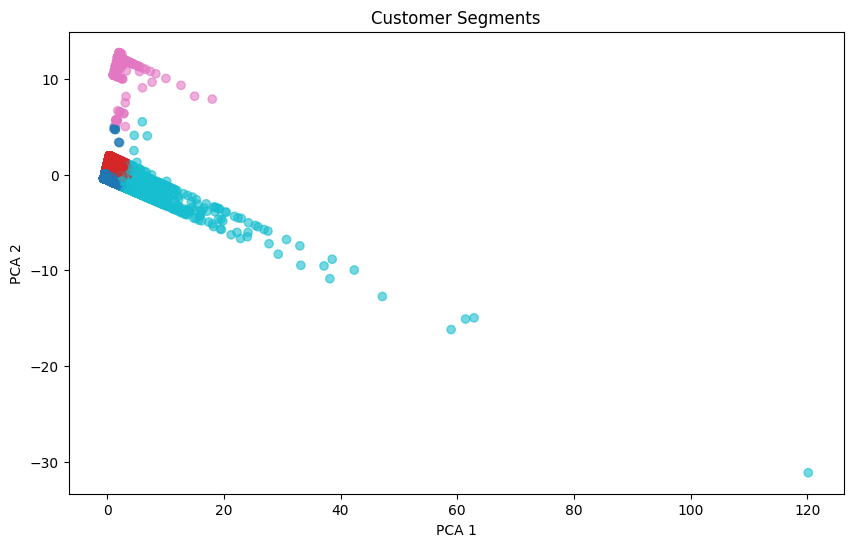

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(features_scaled)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=customer_df["cluster"], cmap="tab10", alpha=0.6)
plt.title("Customer Segments")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [53]:
# Analyze Each Cluster
cluster_summary = customer_df.groupby("cluster").agg({
    "customer_id": "count",
    "total_orders": "mean",
    "total_spent": "mean",
    "return_rate": "mean",
    "avg_review_score": "mean"
}).rename(columns={"customer_id": "num_customers"}).reset_index().round(2)

cluster_summary

,cluster,num_customers,total_orders,total_spent,return_rate,avg_review_score
0,0,72005,1.13,170.54,0.00,4.75
1,1,20848,1.22,200.22,0.00,1.84
2,2,450,1.27,331.57,0.98,1.52
3,3,2117,5.10,1801.53,0.00,3.67


In [54]:
label_map = {
    0: "😊 Happy First-Time Buyers",
    1: "😡 Unsatisfied One-Timers",
    2: "🚨 High-Value Returners",
    3: "💎 Loyal Premium Customers"
}

customer_df["customer_segment"] = customer_df["cluster"].map(label_map)

In [55]:
customer_df["customer_segment"].value_counts()

,count
customer_segment,
😊 Happy First-Time Buyers,72005
😡 Unsatisfied One-Timers,20848
💎 Loyal Premium Customers,2117
🚨 High-Value Returners,450


In [56]:
avg_review_by_customer = df_orders_full.groupby("customer_id")["review_score"].mean().reset_index()
avg_review_by_customer.rename(columns={"review_score": "avg_review_score_by_customer"}, inplace=True)

df_orders_full = df_orders_full.merge(avg_review_by_customer, on="customer_id", how="left")

In [57]:
customer_spending = df_orders_full.groupby("customer_id").agg(
    total_orders_by_customer = ("order_id", "count"),
    total_spent_by_customer = ("payment_value", "sum")
).reset_index()

df_orders_full = df_orders_full.merge(customer_spending, on="customer_id", how="left")

In [58]:
df_orders_full.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'is_returned', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'actual_delivery_days', 'delivery_delay', 'r

In [59]:
# Drop duplicate column
df_orders_full.drop(columns=["total_orders_by_customer_x"], inplace=True)

# Rename the remaining one
df_orders_full.rename(columns={"total_orders_by_customer_y": "total_orders_by_customer"}, inplace=True)

In [60]:
df_orders_full[[
    'avg_review_score_by_customer',
    'total_spent_by_customer',
    'total_orders_by_customer'
]].head()

,avg_review_score_by_customer,total_spent_by_customer,total_orders_by_customer
0,4.0,38.71,3
1,4.0,38.71,3
2,4.0,38.71,3
3,4.0,141.46,1
4,5.0,179.12,1


In [61]:
features = [
    'price', 'freight_value', 'payment_value', 'payment_installments',
    'actual_delivery_days', 'delivery_delay',
    'avg_review_score_by_customer', 'total_spent_by_customer', 'total_orders_by_customer',
    'payment_per_installment'
]

In [62]:
from sklearn.model_selection import train_test_split

X = df_orders_full[features]
y = df_orders_full['is_returned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [63]:
import numpy as np

print("Has NaN values:", X_train.isnull().values.any())
print("Has Inf values:", np.isinf(X_train).values.any())
print("Has -Inf values:", np.isneginf(X_train).values.any())

Has NaN values: True
Has Inf values: True
Has -Inf values: False


In [64]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [65]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [66]:
# Training a Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train the model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_imputed, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test_imputed)
y_proba_lr = lr.predict_proba(X_test_imputed)[:,1]

In [67]:
print("🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("\n🏆 ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))

🔍 Confusion Matrix:
[[23548     0]
 [  114     0]]

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23548
           1       0.00      0.00      0.00       114

    accuracy                           1.00     23662
   macro avg       0.50      0.50      0.50     23662
weighted avg       0.99      1.00      0.99     23662


🏆 ROC-AUC Score: 0.8548600991181878


In [68]:
# Training Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_imputed, y_train)

y_pred_rf = rf.predict(X_test_imputed)
y_proba_rf = rf.predict_proba(X_test_imputed)[:,1]

In [69]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))

Confusion Matrix:
[[23531    17]
 [   76    38]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23548
           1       0.69      0.33      0.45       114

    accuracy                           1.00     23662
   macro avg       0.84      0.67      0.72     23662
weighted avg       1.00      1.00      1.00     23662


ROC-AUC Score: 0.9775786448880822


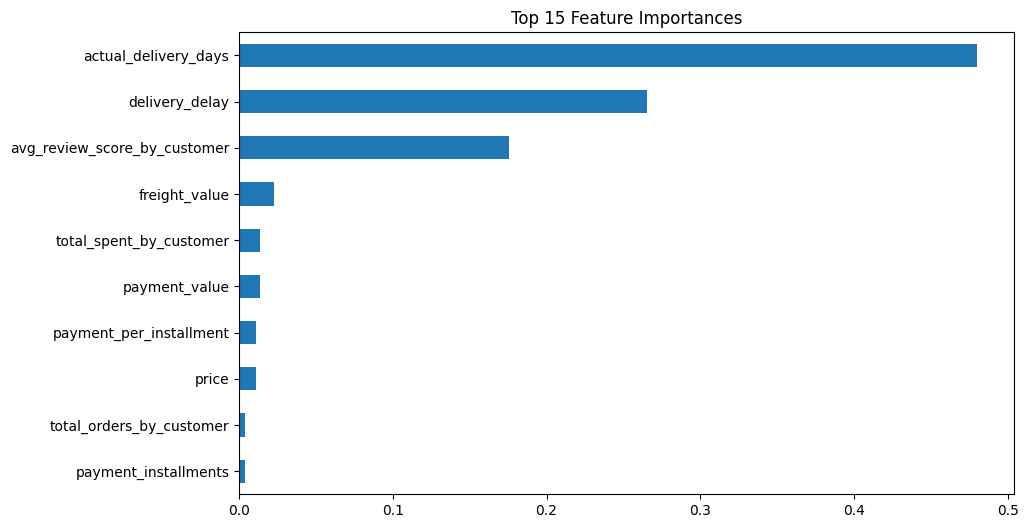

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', figsize=(10,6))
plt.title("Top 15 Feature Importances")
plt.show()

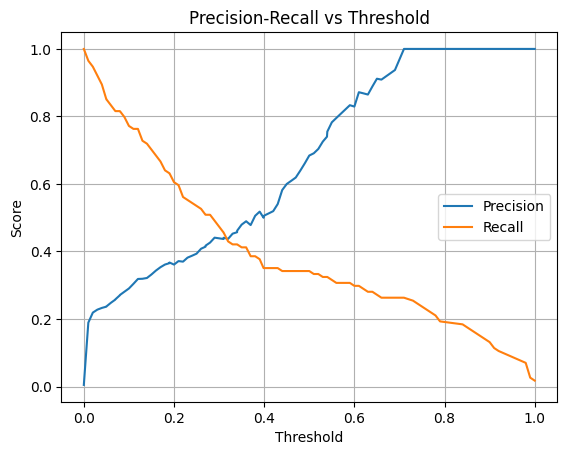

In [71]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()

In [72]:
y_pred_custom_thresh = (y_proba_rf >= 0.3).astype(int)
print(confusion_matrix(y_test, y_pred_custom_thresh))
print(classification_report(y_test, y_pred_custom_thresh))

[[23479    69]
 [   60    54]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23548
           1       0.44      0.47      0.46       114

    accuracy                           0.99     23662
   macro avg       0.72      0.74      0.73     23662
weighted avg       0.99      0.99      0.99     23662



In [73]:
import xgboost as xgb
from xgboost import XGBClassifier

In [74]:
# Initialize XGBoost with class imbalance handling
xgb_model = XGBClassifier(
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [75]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_xgb))

Confusion Matrix:
 [[23377   171]
 [   38    76]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     23548
           1       0.31      0.67      0.42       114

    accuracy                           0.99     23662
   macro avg       0.65      0.83      0.71     23662
weighted avg       1.00      0.99      0.99     23662


ROC-AUC Score: 0.8297024517298001


In [76]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    class_weight='balanced',
    random_state=42
)

lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 456, number of negative: 94192
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1591
[LightGBM] [Info] Number of data points in the train set: 94648, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [77]:
y_pred_lgbm = lgbm.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_lgbm))

Confusion Matrix:
 [[23267   281]
 [   11   103]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     23548
           1       0.27      0.90      0.41       114

    accuracy                           0.99     23662
   macro avg       0.63      0.95      0.70     23662
weighted avg       1.00      0.99      0.99     23662


ROC-AUC Score: 0.9457878495286969


In [78]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [79]:
from catboost import CatBoostClassifier

In [80]:
cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0,
    random_seed=42
)

cat.fit(X_train, y_train)

In [81]:
y_pred_cat = cat.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_cat))

Confusion Matrix:
 [[23537    11]
 [   84    30]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23548
           1       0.73      0.26      0.39       114

    accuracy                           1.00     23662
   macro avg       0.86      0.63      0.69     23662
weighted avg       1.00      1.00      1.00     23662


ROC-AUC Score: 0.6313453818851529


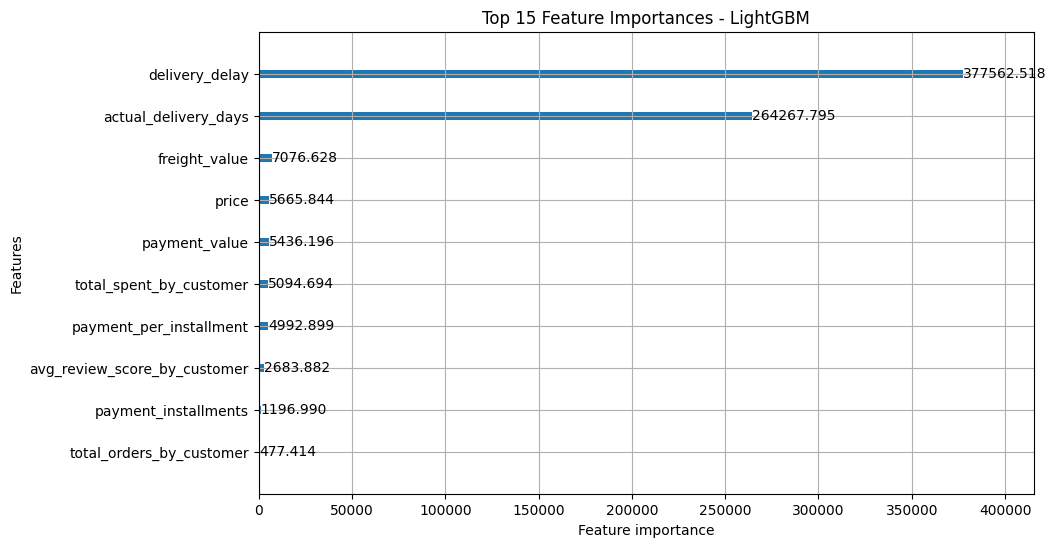

In [82]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Plotting feature importance
lgb.plot_importance(lgbm, max_num_features=15, importance_type='gain', figsize=(10, 6))
plt.title("Top 15 Feature Importances - LightGBM")
plt.show()

In [83]:
import pandas as pd

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False)

importance_df.head(10)

,Feature,Importance
1,freight_value,659
0,price,452
7,total_spent_by_customer,437
9,payment_per_installment,400
2,payment_value,386
6,avg_review_score_by_customer,173
5,delivery_delay,159
4,actual_delivery_days,154
3,payment_installments,105
8,total_orders_by_customer,75


In [84]:
# Merging Geolocation Data

# Step 1: Aggregate geolocation data at zip code level
geo_grouped = geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

# Step 2: Merge customer location info
df_orders_full = df_orders_full.merge(
    geo_grouped,
    how='left',
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix'
).rename(columns={
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'
}).drop(columns=['geolocation_zip_code_prefix'])

# Step 3: Merge seller location info
df_orders_full = df_orders_full.merge(
    geo_grouped,
    how='left',
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix'
).rename(columns={
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'
}).drop(columns=['geolocation_zip_code_prefix'])

In [85]:
df_orders_full.to_excel("Ecommerce_Return_Analysis.xlsx", index=False)

In [86]:
# 1. Install required libraries (if not already installed)
!pip install openpyxl

# 2. Import Libraries
import pandas as pd
import numpy as np

# 3. Load your Excel file
file_path = "/content/Ecommerce_Return_Analysis.xlsx"  # Upload your file to Colab and update this path if needed
df = pd.read_excel(file_path)

# 4. Check for problematic columns
print("🚨 Checking data types and nulls:")
print(df.dtypes)
print("\n🔍 Null values in each column:")
print(df.isnull().sum())

# 5. Fix date columns (convert Excel numeric date to proper datetime)
date_columns = [
    "order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date",
    "order_delivered_customer_date", "order_estimated_delivery_date",
    "shipping_limit_date", "review_creation_date", "review_answer_timestamp"
]

for col in date_columns:
    if col in df.columns:
        try:
            df[col] = pd.to_datetime(df[col], errors='coerce')
        except Exception as e:
            print(f"⚠️ Error converting column '{col}': {e}")

# 6. Remove or fill invalid values (NaN, Inf, etc.)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna("", inplace=True)  # Or use df.fillna(method='ffill') if more appropriate

# 7. Optional: Ensure all column names are clean (no spaces, etc.)
df.columns = df.columns.str.strip().str.replace(" ", "_")

# 8. Export cleaned file
output_path = "/content/Ecommerce_Return_Analysis_CLEAN.xlsx"
df.to_excel(output_path, index=False)
print(f"✅ Cleaned file saved as: {output_path}")

🚨 Checking data types and nulls:
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date             object
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
is_returned                               int64
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
product_category_name                    object
product_name_lenght                     float64
product_description_lenght              float64
product_photos_qty                      float64
product_weight_g                        float64
product